In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from  comprendre_api.Clean_donnees import liste_propre
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb


In [3]:
data = pd.concat([liste_propre(code_commune=None, taille_echantillon=10000)],
                axis=0, 
                ignore_index=True)
data.head(2)

,_id,consommation_energie,classe_consommation_energie,estimation_ges,surface_thermique_lot,classe_estimation_ges,annee_construction,tr002_type_batiment_description,code_insee_commune_actualise,geo_adresse,latitude,longitude,consommation_surface_ratio
0,WRYV9xQCjLUgZ4MAK3wKu,132.0,3.0,29.0,190.0,4.0,5200.0,Maison Individuelle,01430,3 Impasse du Foyer Rural 01160 Varambon,46.040911,5.317098,0.694737
1,y54XQHgRuWB5L1wiVTGJ4,221.0,4.0,3.0,78.2,1.0,2006.0,Logement,05120,Rue de la Bluette 05460 Abriès-Ristolas,44.773510,6.954523,2.826087


In [4]:
data.shape

(4415, 13)

In [5]:
data.isna().sum()

_id                                0
consommation_energie               0
classe_consommation_energie        0
estimation_ges                     0
surface_thermique_lot              0
classe_estimation_ges              0
annee_construction                 0
tr002_type_batiment_description    0
code_insee_commune_actualise       0
geo_adresse                        0
latitude                           0
longitude                          0
consommation_surface_ratio         0
dtype: int64

In [6]:
data.dropna(inplace=True)
data.shape

(4415, 13)

In [7]:
data['geo_adresse'].value_counts()

geo_adresse
Rue du Général de Gaulle (Pont) Saint-Sébastien-sur-Loire    19
Hameau des Rossignols 16000 Angoulême                        14
11bis Rue des Vannes 10800 Saint-Julien-les-Villas           13
1 Rue de la République 10150 Creney-près-Troyes              11
15 Rue Dainville 49000 Angers                                10
                                                             ..
2 Chemin des Corvées 10150 Lavau                              1
Rue Sainte Radegonde 14400 Subles                             1
10 Rue Marie Marvingt 15000 Aurillac                          1
Impasse du Puits 16220 Rouzède                                1
le champ des granges 16120 Mosnac-Saint-Simeux                1
Name: count, Length: 3975, dtype: int64

In [8]:
duplicate_rows = data.duplicated(keep='first')

# Display rows with duplicates
duplicates_df = data[duplicate_rows]
print("Duplicate Rows:")
print(duplicates_df)

# Count the number of duplicates
num_duplicates = duplicate_rows.sum()
print(f"Number of Duplicate Rows: {num_duplicates}")

Duplicate Rows:
Empty DataFrame
Columns: [_id, consommation_energie, classe_consommation_energie, estimation_ges, surface_thermique_lot, classe_estimation_ges, annee_construction, tr002_type_batiment_description, code_insee_commune_actualise, geo_adresse, latitude, longitude, consommation_surface_ratio]
Index: []
Number of Duplicate Rows: 0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4415 entries, 0 to 4414
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              4415 non-null   object 
 1   consommation_energie             4415 non-null   float64
 2   classe_consommation_energie      4415 non-null   float64
 3   estimation_ges                   4415 non-null   float64
 4   surface_thermique_lot            4415 non-null   float64
 5   classe_estimation_ges            4415 non-null   float64
 6   annee_construction               4415 non-null   float64
 7   tr002_type_batiment_description  4415 non-null   object 
 8   code_insee_commune_actualise     4415 non-null   object 
 9   geo_adresse                      4415 non-null   object 
 10  latitude                         4415 non-null   float64
 11  longitude                        4415 non-null   float64
 12  consommation_surface

In [10]:
data['departement']=data['code_insee_commune_actualise'].astype(str).str[:2]
data['departement'] = data['departement'].apply(lambda x: int(x) if x.isnumeric() else int(x[0]))

In [11]:
encoder = OneHotEncoder(sparse=False, drop='first')
building_type_encoded = pd.DataFrame(
    encoder.fit_transform(data[['tr002_type_batiment_description']]), 
    columns=encoder.get_feature_names_out(['tr002_type_batiment_description'])
    )
data_reg = pd.concat([data, building_type_encoded], axis=1)

zip_code_encoded = pd.DataFrame(
    encoder.fit_transform(data_reg[['departement']]), 
    columns=encoder.get_feature_names_out(['departement'])
    )
data_reg = pd.concat([data_reg, zip_code_encoded], axis=1)

# Step 2: Drop the original zip_code column
data_reg  = data_reg .drop(['tr002_type_batiment_description',
                            'code_insee_commune_actualise',
                            'geo_adresse',
                            '_id',
                            'departement'], 
                            axis=1)

data_reg.head(2)


/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,consommation_energie,classe_consommation_energie,estimation_ges,surface_thermique_lot,classe_estimation_ges,annee_construction,latitude,longitude,consommation_surface_ratio,tr002_type_batiment_description_Logement,...,departement_86,departement_87,departement_88,departement_89,departement_90,departement_91,departement_92,departement_93,departement_94,departement_95
0,132.0,3.0,29.0,190.0,4.0,5200.0,46.040911,5.317098,0.694737,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,221.0,4.0,3.0,78.2,1.0,2006.0,44.773510,6.954523,2.826087,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
X = data_reg.drop('classe_consommation_energie', axis=1)
y = data_reg['classe_consommation_energie']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3532, 104), (883, 104), (3532,), (883,))

In [13]:
model = xgb.XGBRegressor()

In [14]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

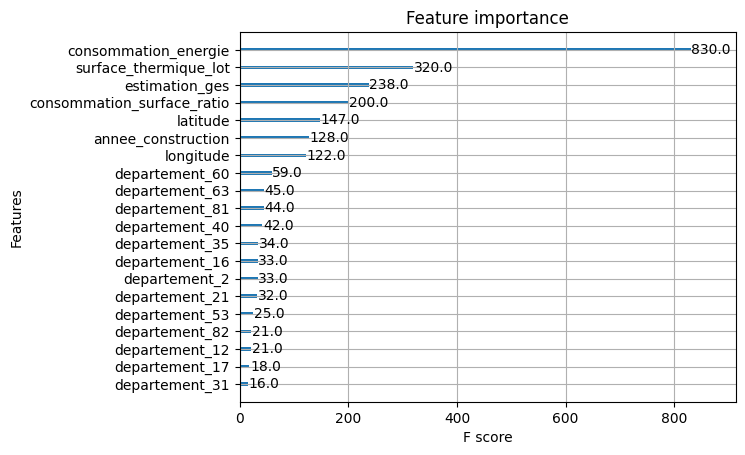

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

xgb.plot_importance(model, ax=plt.gca(), max_num_features=20)


In [16]:
predictions = model.predict(X_test) 
pred_train = model.predict(X_train)
print(r2_score(y_train, pred_train))
print(mean_squared_error(y_train, pred_train))

0.9999988432637087
1.7233930028985977e-06


In [19]:
print(model.score(X_test, y_test))
print(mean_squared_error(y_test, predictions))
print(f"accuracy score is: {accuracy_score(y_test, predictions.round())}")
print(f"precision score is: {precision_score(y_test, predictions.round(), average='macro')}")
print(f"recall score is: {recall_score(y_test, predictions.round(), average='macro')}")
print(f"f1 score is: {f1_score(y_test, predictions.round(), average='macro')}")
print(confusion_matrix(y_test, predictions.round()))


0.9958914756680386
0.006030325952269888
accuracy score is: 0.9909399773499433
precision score is: 0.9497672795853084
recall score is: 0.9462936898897489
f1 score is: 0.9479757850849216
[[  6   2   0   0   0   0   0]
 [  2  23   1   0   0   0   0]
 [  0   0  91   0   0   0   0]
 [  0   0   0 288   2   0   0]
 [  0   0   0   1 272   0   0]
 [  0   0   0   0   0 128   0]
 [  0   0   0   0   0   0  67]]


In [18]:
import plotly.plotly as py
from plotly.graph_objs import *


trace1 = {
  "name": "Random Forest Feature Importance", 
  "type": "bar", 
  "x": ,
  "y": ["_id", 
        "consommation_energie", 
        "classe_consommation_energie", 
        "surface_thermique_lot",
        "estimation_ges", 
        "classe_estimation_ges",
        "annee_construction",
        'latitude', 
        'longitude',
        'departement',
        "tr002_type_batiment_description_Logement",
        "tr002_type_batiment_description_MaisonIndividuelle",],
  "marker": {
    "color": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.109716133987695e-06, 7.703036483386167e-06, 8.461552083370545e-06, 8.663988004906864e-06, 9.020795706973176e-06, 1.004570512055851e-05, 1.5671140853458132e-05, 1.6295659493572165e-05, 1.741906313673886e-05, 2.0100822829957596e-05, 2.2816302915417907e-05, 2.4246803930597424e-05, 2.4757393100676952e-05, 2.500027452719728e-05, 3.3697574059906286e-05, 3.4168653433654525e-05, 3.643041079993551e-05, 3.791934111251367e-05, 4.274469005029469e-05, 4.343263162021663e-05, 4.426027394984055e-05, 4.695600865548089e-05, 4.9565838405169425e-05, 4.978039638947052e-05, 5.0012660874598815e-05, 5.141910875145225e-05, 5.154715590130228e-05, 5.1621482352459386e-05, 5.329878576685483e-05, 5.51707190617985e-05, 5.974094686718682e-05, 5.985800042968552e-05, 6.153456226452275e-05, 6.210374529100839e-05, 6.254914622828774e-05, 6.270436687526173e-05, 6.335711425698183e-05, 6.851079633660588e-05, 7.119194195559193e-05, 7.848857332340006e-05, 8.049331415476887e-05, 8.621532047332815e-05, 9.074794559129119e-05, 9.523879940753821e-05, 9.53698154669919e-05, 9.966178025411473e-05, 0.00010163674209469113, 0.00010213774061058767, 0.00010626285667715481, 0.00010648344892300718, 0.00010651493565651885, 0.00010909040078294162, 0.00011295050924714004, 0.00012086551852608377, 0.00012321821690849878, 0.0001302848088304128, 0.00013085866018109008, 0.00013195222940709937, 0.00013269767028158952, 0.00013285628907335522, 0.00013296900060123736, 0.0001387352136143505, 0.0001408882286795733, 0.00014091380326905175, 0.00014177539789886107, 0.0001433471852318183, 0.00014360727187070127, 0.00015021387287794013, 0.00015117667044461691, 0.0001512398762656828, 0.0001536449801303124, 0.00015577632495893283, 0.00015675205174575755, 0.00016210359626574585, 0.00016272742072407365, 0.00016407179298442474, 0.00016741441198541977, 0.00016806414532989866, 0.00016950806319640025, 0.00016969787473001882, 0.00017459449522339303, 0.0001867943476849605, 0.00019381965003712718, 0.00019413265191160704, 0.0001945649324605474, 0.0001951050598815392, 0.00020095959216767276, 0.0002051363814916192, 0.00020694589464624456, 0.00020786611152972813, 0.0002085610286985377, 0.00020995001424627742, 0.0002117954040242553, 0.00021815132638941106, 0.00022038624854582976, 0.00022774159110143692, 0.0002279980237340525, 0.00023108932092671936, 0.00023155002294300252, 0.00023708188046185416, 0.0002396277379073452, 0.00024033073321547328, 0.00025965740129177666, 0.00027179919448940026, 0.00027680882597748527, 0.0002778101988596563, 0.000283103033530145, 0.0002867293024553309, 0.0002894311278325083, 0.0003019252306737587, 0.0003020444702053275, 0.00030996100099880817, 0.00033550386951376374, 0.00034786901562607574, 0.0003500594652651233, 0.00035054739021905964, 0.000356989405476307, 0.00035860221109012885, 0.0003616861617658578, 0.00037204659224696583, 0.0003786033770473058, 0.0003842468481484238, 0.00038448943135944167, 0.00038534863276875963, 0.00038860753677546497, 0.00039207074425250165, 0.00040189086545742346, 0.000410173021040104, 0.0004478865152072518, 0.0004567688820849058, 0.0004589990956313546, 0.0005028927245470937, 0.0005150819468571212, 0.0005188389383163014, 0.0005404916792288722, 0.0005520216681392972, 0.0005555107615488306, 0.0005625853532960272, 0.0005704158918594985, 0.000608176395113242, 0.000617742926859644, 0.00062415967014512, 0.0006402769532744297, 0.0006456327963114584, 0.0006496921695966541, 0.0006501359165780403, 0.0006557623149041427, 0.000715203145657671, 0.0007305701078484692, 0.000748899425528294, 0.0007567351083934106, 0.0007587782804650318, 0.0007604865996432056, 0.0007807033077872844, 0.000784202924362991, 0.0008083979053611966, 0.0008186457739020104, 0.0008220672529574241, 0.0008358055498667037, 0.000851413728871102, 0.0008538190956282847, 0.000857976540212332, 0.000880729289400861, 0.0008839400928080532, 0.00092762318219349, 0.0009416400446946571, 0.0009466184489675222, 0.00094786827026551, 0.000989637234795969, 0.0010155009357250297, 0.0010538329490184625, 0.0010539211106009197, 0.0010547421062438243, 0.0010737290725892192, 0.0010839107207496878, 0.0010946461090414188, 0.0010963604431664194, 0.0011141584335953745, 0.001122551438474435, 0.0011386589964031198, 0.0011485752220115706, 0.0011715913632396075, 0.0012547842594984933, 0.0012653245149289254, 0.0012656561998800658, 0.0013218647967237248, 0.0014038313505240403, 0.0014293543962963478, 0.001519090028695659, 0.0015743801748051797, 0.0016161234620355772, 0.0016167382428944799, 0.0017036889552034646, 0.0017044580050488097, 0.0017572834900856866, 0.0019005080980835198, 0.0026405461759789785, 0.0027679204612043873, 0.002859665694595686, 0.003380825002576292, 0.004289142410134977, 0.004385995781812278, 0.004401371300564893, 0.004947092571305504, 0.00497539015260427, 0.005318648508995366, 0.005973821967933667, 0.007410073626142893, 0.007906564454379624, 0.009940164257351922, 0.010792403274297207, 0.0109642333467352, 0.01110272406021579, 0.011396153940669028, 0.01242676564857529, 0.01306945731155104, 0.018676903640988212, 0.04913950192384366, 0.06655827427167903, 0.29631340649339394, 0.343293126769514], 
    "colorscale": "Viridis", 
    "reversescale": True
  }, 
  "orientation": "h"
}
data = Data([trace1])
layout = {
  "title": "Barplot of feature importance", 
  "width": 1000, 
  "yaxis": {
    "showgrid": False, 
    "showline": False, 
    "showticklabels": True
  }, 
  "height": 2000, 
  "margin": {"l": 300}
}
fig = Figure(data=data, layout=layout)
plot_url = py.plot(fig)


SyntaxError: expression expected after dictionary key and ':' (944089150.py, line 8)